In [1]:
import polars as pl
import json
from pathlib import Path
import altair as alt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import helper
import os

### Helper functions

In [2]:
def process_one_basin(basin):
    file_path = f'data/{basin}.json'

    with open(file_path, 'r') as file:
        # Read in json data (one file for each basin)
        data = json.load(file)
         
        # Convert json data to a list of dicts (to facilitate to conversion to a dataframe)
        records = [
            {
                'year': year,
                'named_storms': values[0],
                'named_storm_days': values[1],
                'hurricanes': values[2],
                'hurricane_days': values[3],
                'major_hurricanes': values[4],
                'major_hurricane_days': values[5],
                'ace': values[6],
            }
            for year, values in data.items()
        ]

        # Make a dataframe from the list-o-dicts
        df = (
            pl.DataFrame(records)
            .with_columns(
                pl.lit(basin).alias('basin'),
                pl.col('year').cast(pl.UInt16),
            )
        )

        # Put 'basin' column first and scoot the rest to the right
        cols = df.columns
        cols = cols[-1:] + cols[:-1]

    return df[cols]

In [3]:
def combine_input_sources():
    # Grab data from source .json files
    data_dir = Path('data')
    json_files = [file for file in data_dir.glob('*.json') if file.is_file()]

    # Combine all basin's pertinent data into one dataframe
    master_df = pl.DataFrame()

    for file in json_files:
        basin = file.stem
        master_df = master_df.vstack(process_one_basin(basin))

    return master_df

In [4]:
def extract_chart_data(master_df):
    # Grab only the data needed for the chart
    chart_df = (
        master_df
        .filter(
            pl.col('year').is_between(1980, 2023),
            ~pl.col('basin').is_in(['global', 'northernhemisphere', 'southernhemisphere'])
        )
        .select(['basin', 'year', 'major_hurricanes'])
    )

    # Convert the long table to wide
    wide = chart_df.pivot(on='year', values='major_hurricanes')

    # Write df to file if necessary
    file_path = 'data/chart_source.parquet'
    if os.path.exists(file_path):
        print('No action necessary.')
    else:
        wide.write_parquet(file_path)
        print('Wrote chart_source.parquet.')

    return wide 

### Write combined data file if needed

In [5]:
extract_chart_data(combine_input_sources())

No action necessary.


basin,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""northeastpacific""",3,1,5,8,7,8,3,4,3,4,6,5,10,9,5,3,2,7,6,2,2,2,6,0,3,2,6,1,2,5,2,6,5,1,9,11,6,4,10,4,3,2,4,8
"""southindian""",6,5,2,0,3,2,5,0,2,6,4,2,7,2,7,7,7,5,2,6,7,4,7,5,6,4,5,8,5,4,5,1,2,6,7,5,3,2,4,11,5,3,5,5
"""northatlantic""",2,3,1,1,1,3,0,1,3,2,1,2,1,1,0,5,6,1,3,5,3,4,2,3,6,7,2,2,5,2,5,4,2,0,2,2,4,6,2,3,6,4,2,3
"""southpacific""",1,0,0,5,1,5,0,1,2,4,1,1,4,5,4,1,1,3,4,1,1,1,1,6,2,5,2,1,3,1,4,3,1,3,2,4,2,2,3,2,1,2,0,2
"""northindian""",0,0,1,0,0,0,0,0,1,0,1,1,1,0,1,1,1,1,1,3,0,1,0,0,0,0,1,2,1,0,2,0,0,1,2,2,0,1,2,5,2,1,0,3
"""northwestpacific""",9,6,12,6,9,6,8,12,7,9,8,11,11,9,12,7,10,12,5,4,7,12,11,11,14,10,10,9,8,7,4,7,10,11,7,16,11,5,9,11,7,5,5,8


### Plot the data

In [6]:
chart_source = pl.read_parquet('./data/chart_source.parquet')

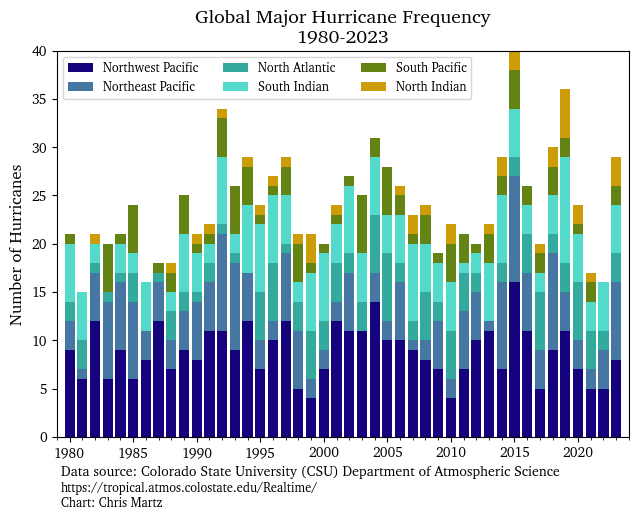

In [7]:
helper.make_chart(chart_source)

### TODO
* Uggghhh!!!  I cannot get the figure text italicized.

I'm obviously missing some fundamental understanding of matplotlib and/or notebook rendering.  If I specify the exact pixel dimensions then I can't match the chart.  If I fudge the dimensions then I can match the chart.

### Concerns

#### Concern: totals do not match
There are too many "close but not quite" values.

Could be due to source data files changing.  (Data from the web site is just a snapshot.)

#### Concern: consistent stack order
Chris' stack order is not consistent year after year.

When it exists, North Indian should be the top-most stack piece.

Yet 1990, 1992, 2006, 2013, and 2014 all show North Indian be the second top-most stack piece.


#### Concern: multiple stack pieces in the same year

eg, 1990 has two South Indian stack pieces.  So does 1992.

This raises concern about the aggregation of data.
